Logistic Regression avec Titanic Kaggle 

https://www.kaggle.com/thulani96/titanic-dataset-analysis-with-seaborn

https://www.kaggle.com/sashr07/kaggle-titanic-tutorial

# Importation et examen rapide des données :

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df_train =pd.read_csv('data/train.csv',sep=',') 
df_test = pd.read_csv("data/test.csv",sep=',',) 

In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_train.info())
print(df_test.info())

(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare    

In [5]:
# check missing values in train data
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Détermination et visualisation des caractéristiques importantes : 

Dans ce cas, comprendre le désastre du Titanic et typiquement quelles variables peuvent affecter la fait d'avoir été survivant est important. Quiconque a regardé le film Titanic sait que les femmes et les enfants étaient mis en premier dans les bateaux de survie, tout comme dans la vraie vie. Vous vous rappelerez aussi la disparité des classes entre les passagers.

Ceci nous indique que l'Age, le Genre et la Classe peuvent etre des bons indices de survie. Nous allons donc commencer par exploer ces caractéristiques en visualisant les données.

## Nombres de survivants en fonction du genre : 

Survived    0    1
Sex               
female     81  233
male      468  109


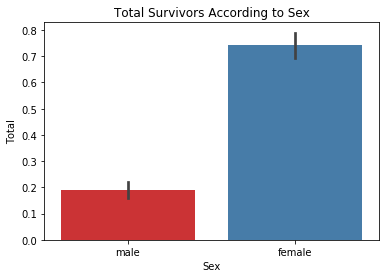

In [7]:
print(pd.crosstab(df_train["Sex"],df_train.Survived))
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax = sns.barplot(x = 'Sex', y = 'Survived', palette = 'Set1', data = df_train)
ax.set(title = 'Total Survivors According to Sex', xlabel = 'Sex', ylabel='Total')
plt.show()

On peut voir immédiatement que les femmes ont survécues dans une plus large proportion que les hommes, faisons de meme avec la colonnes Pclass.

## Proportion de survivants en fonction de la classe :

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


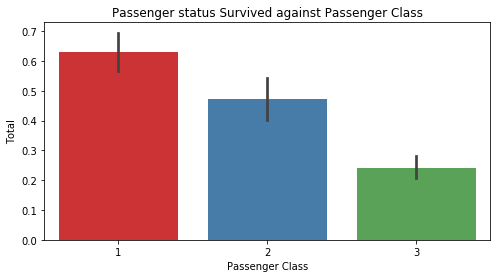

In [8]:
print(pd.crosstab(df_train["Pclass"],df_train.Survived))
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax = sns.barplot(x = 'Pclass', y = 'Survived', palette = 'Set1', data = df_train)
ax.set(title = 'Passenger status Survived against Passenger Class', 
       xlabel = 'Passenger Class', ylabel = 'Total')
plt.show()

# Exploration et conversion de la colonne Age : 

Les colonnes Sex and PClass sont ce qu'on appelle des caractérisiques catégoriques (categorial features). Cela signifie que les valeurs sont représentées par quelques options (par exemple quand le passasger est homme ou femme)

La colonne des ages contient des valeurs allant de 0,45 à 80. L'autre point important c'est qu'il y a 714 valeurs dans cette colonnes, un peu moins que les 814 lignes du train data set vu plus haut. 

Tout cela implique que la colonne des ages doit etre traité légèrement différemment du au fait que c'est une colonne de valeurs numériques continues. Un des moyen de regarder la distribution de ces valeurs est d'utiliser un histogramme. Nous pouvons créer deux histogrammes pour comparer visuellement ceux qui ont survécu de ceux qui sont morts, à travers les ages.

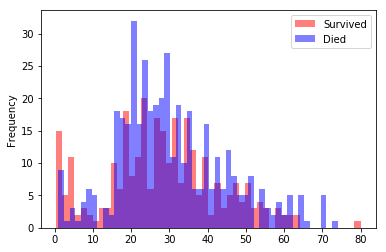

In [9]:
survived = df_train[df_train["Survived"] == 1]
died = df_train[df_train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

La relation ici n'est pas évidente, mais nous pouvons voir que certaines catégories d'ages on survécue la ou les barres rouges sont plus hautes que les barres bleues.

Pour que cela soit plus pratique pour notre modèle de learning machine, nous pouvons séparer cette caractéristique continue en une caractéristique catégorique en divisant celle ci en morceaux. Nous pouvons utiliser la fonction pandas.cut() pour cela.

In [10]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']

df_train = process_age(df_train,cut_points,label_names)
df_test = process_age(df_test,cut_points,label_names)


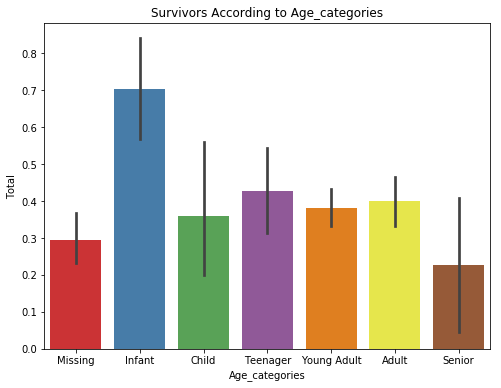

In [11]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.barplot(x = 'Age_categories', y = 'Survived', palette = 'Set1', data = df_train)
ax.set(title = 'Survivors According to Age_categories', xlabel = 'Age_categories', ylabel='Total')
plt.show()

# Préparation des données pour le Machine Learning :

Donc nous avons donc identifié trois colonnes qui peuvent etre utile pour trouver les survivants :
    - Sex
    - Pclass
    - Age, ou plus précisément notre nouvelle caractéristique Age_categories
    
Avant de construire notre model nous avons besoin de préparer ces colonnes pour le machine learning.La pluspart des algorithms de machine learning ne peuvent pas comprendre les labels de text, nous devons donc convertir nos valeurs en nombres.

De plus nous devons faire attention de ne pas créer des relations numériques la ou il n'y en a pas. Si nous examinons les valeurs de la colonnes Pclass,nous savons qu'elles sont 1, 2, and 3.

Mais alors que la classe de chaque passager a certainement une relation ordonnée, la relation entre chaque class n'est pas la meme qu'entre les nombres 1,2,3. Par exemple la seconde class n'a pas une valeur double de la première classe, pas plus que la troisième class a une valeur triple de la première classe.

Pour éliminer cette relation nous pouvons créer une dummy colonne pour chaque valeur unique dans Pclass.

In [12]:
column_name = "Pclass"
df = df_train
dummies = pd.get_dummies(df[column_name],prefix=column_name)
dummies.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [13]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

df_train = create_dummies(df_train,"Pclass")
df_test = create_dummies(df_test,"Pclass")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0,0,1


In [14]:
df_train = create_dummies(df_train,"Sex")
df_test = create_dummies(df_test,"Sex")
df_train = create_dummies(df_train,"Age_categories")
df_test = create_dummies(df_test,"Age_categories")

In [15]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


# Modèle de Machine learning avec régression logistique :

In [16]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

In [17]:
all_X = df_train[columns]
all_y = df_train['Survived']

#dividing the data in training and test data 
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2,random_state=0)

print(train_X.shape)

lr = LogisticRegression(solver='lbfgs')
model = lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))

(712, 12)
Accuracy of logistic regression classifier on test set: 0.81


In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(conf_matrix, columns=['Survived', 'Died'], index=[['Survived', 'Died']])

,Survived,Died
Survived,96,14
Died,20,49


In [19]:
# Function for plotting coef of each feature
def plot_lr_coefs(X, lr):
    fig, ax = plt.subplots()
    xlabels = X.columns.values.tolist()
    yvalues = lr.coef_[0,]
    index = np.arange(len(yvalues))
    bar_width = 1
    opacity = 0.4
    rects = plt.bar(index, yvalues,bar_width, alpha=opacity,color='b',label="Plot of features")
    plt.ylabel('Values')
    plt.title('Features')
    plt.xticks(index, xlabels,rotation=45)
    plt.legend()
    plt.tight_layout() 

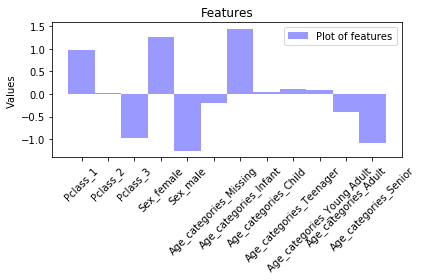

In [20]:
plot_lr_coefs(train_X,model)    